In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pdb
import copy

import sys
sys.path.append("..")
sys.path.append("../third_party")

from cln import data
from cln import contamination
from cln.T_estimation import AnchorPointsEstimation
from cln.utils import evaluate_predictions, estimate_rho
from cln.classification import MarginalLabelNoiseConformal
from third_party import arc

In [2]:
# Define default parameters
exp_num = 1
data_name = 'synthetic1'
num_var = 20
K = 4
signal = 1
model_name = 'RFC'
epsilon = 0.2
nu = 0
contamination_model = "uniform"
n_train = 10000
n_cal = 5000
seed = 5

In [3]:
gamma_vec = np.asarray([0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2], dtype=float)

In [4]:
# Define other constant parameters
estimate = "none"
n_test = 2000
batch_size = 20
allow_empty = True
asymptotic_h_start = 1/400
asymptotic_MC_samples = 10000

# Initialize the data distribution
if data_name == "synthetic1":
    data_distribution = data.DataModel_1(K, num_var, signal=signal, random_state=seed)
elif data_name == "synthetic2":
    data_distribution = data.DataModel_2(K, num_var, signal=signal, random_state=seed)
elif data_name == "synthetic3":
    data_distribution = data.DataModel_3(K, num_var, signal=signal, random_state=seed)
else:
    print("Unknown data distribution!")
    sys.stdout.flush()
    exit(-1)

In [5]:
# Estimate the label proportions from the population model
rho = data_distribution.estimate_rho()

# Initialize noise contamination process
if contamination_model == "uniform":
    T = contamination.construct_T_matrix_simple(K, epsilon)
    M = contamination.convert_T_to_M(T,rho)
elif contamination_model == "block":
    T = contamination.construct_T_matrix_block(K, epsilon)
    M = contamination.convert_T_to_M(T,rho)
elif contamination_model == "RRB":
    T = contamination.construct_T_matrix_block_RR(K, epsilon, nu)
    M = contamination.convert_T_to_M(T,rho)
elif contamination_model == "random":
    T = contamination.construct_T_matrix_random(K, epsilon, random_state=seed)
    M = contamination.convert_T_to_M(T,rho)
else:
    print("Unknown contamination (M) model!")
    sys.stdout.flush()
    exit(-1)

# Compute the contaminated label proportions
rho_tilde = np.dot(T, rho)

In [6]:
# Initialize black-box model
if model_name == 'RFC':
    black_box = arc.black_boxes.RFC(n_estimators=100)
elif model_name == 'SVC':
    black_box = arc.black_boxes.SVC(clip_proba_factor = 1e-5)
elif model_name == 'NN':
    black_box = arc.black_boxes.NNet(max_iter=100)
else:
    print("Unknown model!")
    sys.stdout.flush()
    exit(-1)

In [7]:
# Add important parameters to table of results
header = pd.DataFrame({'data':[data_name], 'num_var':[num_var], 'K':[K],
                       'signal':[signal], 'n_train':[n_train], 'n_cal':[n_cal],
                       'epsilon':[epsilon], 'nu':[nu], 'contamination':[contamination_model],
                       'model_name':[model_name], 'estimate':[estimate], 'seed':[seed]})

# Output file
outfile_prefix = "exp"+str(exp_num) + "/" + data_name + "_p" + str(num_var)
outfile_prefix += "_K" + str(K) + "_signal" + str(signal) + "_" + model_name
outfile_prefix += "_eps" + str(epsilon) + "_nu" + str(nu) + "_" + contamination_model
outfile_prefix += "_nt" + str(n_train) + "_nc" + str(n_cal) + "_est" + estimate + "_seed" + str(seed)
print("Output file: {:s}.".format("results/"+outfile_prefix), end="\n")
sys.stdout.flush()

Output file: results/exp1/synthetic1_p20_K4_signal1_RFC_eps0.2_nu0_uniform_nt10000_nc5000_estnone_seed5.


## Single Experiment

In [8]:
random_state=2025

In [9]:
print("\nRunning experiment in batch {:d}...".format(random_state))
sys.stdout.flush()

# Generate a large data set
print("\nGenerating data...", end=' ')
sys.stdout.flush()
data_distribution.set_seed(random_state+1)
X_all, Y_all = data_distribution.sample(n_train+n_cal+n_test)
print("Done.")
sys.stdout.flush()

# Separate the test set
X, X_test, Y, Y_test = train_test_split(X_all, Y_all, test_size=n_test, random_state=random_state+2)

# Generate the contaminated labels
print("Generating contaminated labels...", end=' ')
sys.stdout.flush()
contamination_process = contamination.LinearContaminationModel(T, random_state=random_state+3)
Yt = contamination_process.sample_labels(Y)
print("Done.")
sys.stdout.flush()

# Estimate (if applicable) the label contamination model
if estimate=="none":
    rho_tilde_hat = rho_tilde
elif estimate=="rho":
    rho_tilde_hat = estimate_rho(Yt, K)
else:
    print("Unknown estimation option!")
    sys.stdout.flush()
    exit(-1)

# Separate data into training and calibration
X_train, X_cal, Yt_train, Yt_cal = train_test_split(X, Yt, test_size=n_cal, random_state=random_state)

# Fit the point predictor on the training set
black_box_pt = copy.deepcopy(black_box)
black_box_pt.fit(X_train, Yt_train)


Running experiment in batch 2025...

Generating data... Done.
Generating contaminated labels... Done.


In [22]:
## Anchor points method for T estimation
method = AnchorPointsEstimation(X_cal, Yt_cal, K, black_box_pt, estimation_method="empirical", calibrate_gamma=True, gamma_vec=gamma_vec, elbow_detection_method="drop", drop=0.01)
T_hat, _, gamma_opt, accuracy_tilde_vec = method.get_estimate()

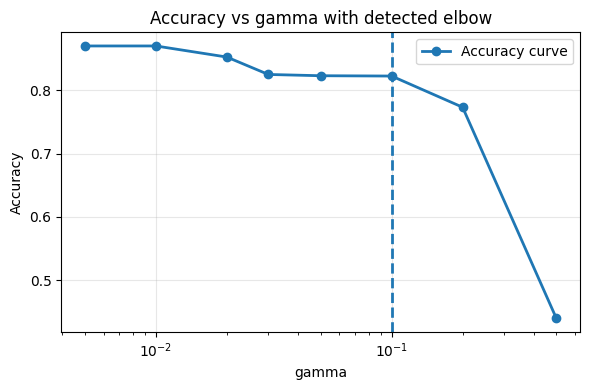

In [23]:
plt.figure(figsize=(6, 4))
plt.plot(gamma_vec, accuracy_tilde_vec, marker='o', linewidth=2, label="Accuracy curve")
plt.axvline(
    gamma_opt,
    linestyle="--",
    linewidth=2
)
plt.xscale("log")
plt.xlabel("gamma")
plt.ylabel("Accuracy")
plt.title("Accuracy vs gamma with detected elbow")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [12]:
print(T_hat)

[[0.814 0.054 0.066 0.052]
 [0.066 0.818 0.052 0.06 ]
 [0.06  0.064 0.818 0.048]
 [0.06  0.064 0.064 0.84 ]]


In [13]:
print(T)

[[0.85 0.05 0.05 0.05]
 [0.05 0.85 0.05 0.05]
 [0.05 0.05 0.85 0.05]
 [0.05 0.05 0.05 0.85]]


## Repeated Experiments

In [8]:
# Describe the experiment
def run_experiment(random_state):
    print("\nRunning experiment in batch {:d}...".format(random_state))
    sys.stdout.flush()

    # Generate a large data set
    print("\nGenerating data...", end=' ')
    sys.stdout.flush()
    data_distribution.set_seed(random_state+1)
    X_all, Y_all = data_distribution.sample(n_train+n_cal+n_test)
    print("Done.")
    sys.stdout.flush()

    # Separate the test set
    X, X_test, Y, Y_test = train_test_split(X_all, Y_all, test_size=n_test, random_state=random_state+2)

    # Generate the contaminated labels
    print("Generating contaminated labels...", end=' ')
    sys.stdout.flush()
    contamination_process = contamination.LinearContaminationModel(T, random_state=random_state+3)
    Yt = contamination_process.sample_labels(Y)
    print("Done.")
    sys.stdout.flush()

    # Estimate (if applicable) the label contamination model
    if estimate=="none":
        rho_tilde_hat = rho_tilde
    elif estimate=="rho":
        rho_tilde_hat = estimate_rho(Yt, K)
    else:
        print("Unknown estimation option!")
        sys.stdout.flush()
        exit(-1)

    # Separate data into training and calibration
    X_train, X_cal, _, Y_cal, Yt_train, Yt_cal = train_test_split(X, Y, Yt, test_size=n_cal, random_state=random_state)

    # Fit the point predictor on the training set
    black_box_pt = copy.deepcopy(black_box)
    black_box_pt.fit(X_train, Yt_train)

    ## Anchor points method for T estimation
    method = AnchorPointsEstimation(X_cal, Yt_cal, K, black_box_pt, estimation_method="empirical", calibrate_gamma=True, gamma_vec=gamma_vec, elbow_detection_method="D2L")
    T_hat_D2L, _, gamma_opt, _ = method.get_estimate()

    method = AnchorPointsEstimation(X_cal, Yt_cal, K, black_box_pt, estimation_method="empirical", calibrate_gamma=True, gamma_vec=gamma_vec, elbow_detection_method="drop", drop=0.1)
    T_hat_drop_1, _, gamma_opt, _ = method.get_estimate()

    method = AnchorPointsEstimation(X_cal, Yt_cal, K, black_box_pt, estimation_method="empirical", calibrate_gamma=True, gamma_vec=gamma_vec, elbow_detection_method="drop", drop=0.05)
    T_hat_drop_05, _, gamma_opt, _ = method.get_estimate()

    method = AnchorPointsEstimation(X_cal, Yt_cal, K, black_box_pt, estimation_method="empirical", calibrate_gamma=True, gamma_vec=gamma_vec, elbow_detection_method="drop", drop=0.01)
    T_hat_drop_01, _, gamma_opt, _ = method.get_estimate()

     ## Anchor points method for parametric T estimation
    method = AnchorPointsEstimation(X_cal, Yt_cal, K, black_box_pt, estimation_method="empirical_parametricRR", gamma=gamma_opt)
    T_hat_param, _, _, _ = method.get_estimate()

    # Estimate using all the clean/noisy labels correspondence
    T_hat_clean = np.zeros((K, K), dtype=float)
    for l in range(K):
        idx = (Y_cal == l)
        n_l = np.sum(idx)
        if n_l > 0:
            counts = np.bincount(Yt_cal[idx], minlength=K)
            T_hat_clean[:, l] = counts / n_l
        else:
            # Fallback if a class i does not appear in Y_train2
            T_hat_clean[:, l] = np.ones(K) / K
    col_sums = T_hat_clean.sum(axis=0, keepdims=True)
    T_hat_clean /= col_sums

    # Get dataset of anchor points
    X_anchor, Y_anchor = method.get_anchor_dataset(X_cal)

    alpha = 0.1
    guarantee = 'marginal'

    res = pd.DataFrame({})

    print("\nSeeking {:s} coverage at level {:.2f}.".format(guarantee, 1-alpha))

    # Define a dictionary of methods with their names and corresponding initialization parameters
    methods = {
        "Standard": lambda: arc.methods.SplitConformal(X, Yt, black_box_pt, K, alpha, n_cal=n_cal,
                                                        pre_trained=True, random_state=random_state),

        "Standard using AP": lambda: arc.methods.SplitConformal(X_anchor, Y_anchor, black_box_pt, K, alpha, n_cal=-1,
                                                        pre_trained=True, random_state=random_state),

        "Adaptive optimized+": lambda: MarginalLabelNoiseConformal(X, Yt, black_box_pt, K, alpha, n_cal=n_cal,
                                                                    epsilon=epsilon, T=T, rho_tilde=rho_tilde_hat,
                                                                    allow_empty=allow_empty, method="improved",
                                                                    optimized=True, optimistic=False, verbose=False,
                                                                    pre_trained=True, random_state=random_state),

        "Adaptive optimized+ clean": lambda: MarginalLabelNoiseConformal(X, Yt, black_box_pt, K, alpha, n_cal=n_cal,
                                                                    epsilon=epsilon, T=T_hat_clean, rho_tilde=rho_tilde_hat,
                                                                    allow_empty=allow_empty, method="improved",
                                                                    optimized=True, optimistic=False, verbose=False,
                                                                    pre_trained=True, random_state=random_state),

        "Adaptive optimized+ AP drop01": lambda: MarginalLabelNoiseConformal(X, Yt, black_box_pt, K, alpha, n_cal=n_cal,
                                                                    epsilon=epsilon, T=T_hat_drop_01, rho_tilde=rho_tilde_hat,
                                                                    allow_empty=allow_empty, method="improved",
                                                                    optimized=True, optimistic=False, verbose=False,
                                                                    pre_trained=True, random_state=random_state),

        "Adaptive optimized+ AP drop05": lambda: MarginalLabelNoiseConformal(X, Yt, black_box_pt, K, alpha, n_cal=n_cal,
                                                                    epsilon=epsilon, T=T_hat_drop_05, rho_tilde=rho_tilde_hat,
                                                                    allow_empty=allow_empty, method="improved",
                                                                    optimized=True, optimistic=False, verbose=False,
                                                                    pre_trained=True, random_state=random_state),

        "Adaptive optimized+ AP drop1": lambda: MarginalLabelNoiseConformal(X, Yt, black_box_pt, K, alpha, n_cal=n_cal,
                                                                    epsilon=epsilon, T=T_hat_drop_1, rho_tilde=rho_tilde_hat,
                                                                    allow_empty=allow_empty, method="improved",
                                                                    optimized=True, optimistic=False, verbose=False,
                                                                    pre_trained=True, random_state=random_state),
        
        "Adaptive optimized+ AP D2L": lambda: MarginalLabelNoiseConformal(X, Yt, black_box_pt, K, alpha, n_cal=n_cal,
                                                                    epsilon=epsilon, T=T_hat_D2L, rho_tilde=rho_tilde_hat,
                                                                    allow_empty=allow_empty, method="improved",
                                                                    optimized=True, optimistic=False, verbose=False,
                                                                    pre_trained=True, random_state=random_state),    

        "Adaptive optimized+ APparam": lambda: MarginalLabelNoiseConformal(X, Yt, black_box_pt, K, alpha, n_cal=n_cal,
                                                                    epsilon=epsilon, T=T_hat_param, rho_tilde=rho_tilde_hat,
                                                                    allow_empty=allow_empty, method="improved",
                                                                    optimized=True, optimistic=False, verbose=False,
                                                                    pre_trained=True, random_state=random_state)

    }

    # Initialize an empty list to store the evaluation results
    res_list = []

    # Loop through the methods, apply them, and evaluate the results
    for method_name, method_func in methods.items():
        print(f"Applying {method_name} method...", end=' ')
        sys.stdout.flush()

        # Initialize and apply the method
        method = method_func()
        predictions = method.predict(X_test)

        print("Done.")
        sys.stdout.flush()

        # Evaluate the method
        res_new = evaluate_predictions(predictions, X_test, Y_test, K, verbose=False)
        res_new['Method'] = method_name
        res_new['Guarantee'] = guarantee
        res_new['Alpha'] = alpha
        res_new['random_state'] = random_state

        # Append the result to the results list
        res_list.append(res_new)

    # Combine all results into a single DataFrame
    res = pd.concat(res_list)

    print(res)

    return res

In [9]:
# Run all experiments
results = pd.DataFrame({})
for batch in np.arange(1,batch_size+1):
    res = run_experiment(1000*seed+batch-1000)
    results = pd.concat([results, res])

    # Save results
    outfile = "results/" + outfile_prefix + ".txt"
    results_out = pd.concat([header,results], axis=1)
    results_out.to_csv(outfile, index=False, float_format="%.5f")

print("\nPreview of results:")
print(results)
sys.stdout.flush()

print("\nSummary of results:")
summary = results.groupby(['Alpha', 'Guarantee', 'Method', 'Label']).agg(['mean','std']).reset_index()
print(summary)
sys.stdout.flush()


print("\nFinished.\nResults written to {:s}\n".format(outfile))
sys.stdout.flush()


Running experiment in batch 4001...

Generating data... Done.
Generating contaminated labels... Done.

Seeking marginal coverage at level 0.90.
Applying Standard method... Done.
Applying Standard using AP method... Done.
Applying Adaptive optimized+ method... Done.
Applying Adaptive optimized+ clean method... Done.
Applying Adaptive optimized+ AP drop01 method... Done.
Applying Adaptive optimized+ AP drop05 method... Done.
Applying Adaptive optimized+ AP drop1 method... Done.
Applying Adaptive optimized+ AP D2L method... Done.
Applying Adaptive optimized+ APparam method... Done.
   Coverage    Size     Label                         Method Guarantee  Alpha   
0    0.9805  2.3580  marginal                       Standard  marginal    0.1  \
0    0.8785  1.3865  marginal              Standard using AP  marginal    0.1   
0    0.9200  1.5845  marginal            Adaptive optimized+  marginal    0.1   
0    0.9220  1.6010  marginal      Adaptive optimized+ clean  marginal    0.1   
0    0.9

# New data generating scheme

In [ ]:
# Define default parameters
exp_num = 1
data_name = 'synthetic1'
num_var = 20
K = 4
signal = 1
model_name = 'RFC'
epsilon = 0.2
nu = 0
contamination_model = "uniform"
n_train = 10000
n_cal = 5000
seed = 5

In [ ]:
gamma_vec = np.asarray([0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2], dtype=float)

In [ ]:
# Define other constant parameters
estimate = "none"
n_test = 2000
batch_size = 20
allow_empty = True
asymptotic_h_start = 1/400
asymptotic_MC_samples = 10000

# Initialize the data distribution
if data_name == "synthetic1":
    data_distribution = data.DataModel_1(K, num_var, signal=signal, random_state=seed)
elif data_name == "synthetic2":
    data_distribution = data.DataModel_2(K, num_var, signal=signal, random_state=seed)
elif data_name == "synthetic3":
    data_distribution = data.DataModel_3(K, num_var, signal=signal, random_state=seed)
elif data_name == "synthetic5":
    data_distribution = data.DataModel_5(K, num_var, signal=signal, random_state=seed)
else:
    print("Unknown data distribution!")
    sys.stdout.flush()
    exit(-1)

In [ ]:
# Estimate the label proportions from the population model
rho = data_distribution.estimate_rho()

# Initialize noise contamination process
if contamination_model == "uniform":
    T = contamination.construct_T_matrix_simple(K, epsilon)
    M = contamination.convert_T_to_M(T,rho)
elif contamination_model == "block":
    T = contamination.construct_T_matrix_block(K, epsilon)
    M = contamination.convert_T_to_M(T,rho)
elif contamination_model == "RRB":
    T = contamination.construct_T_matrix_block_RR(K, epsilon, nu)
    M = contamination.convert_T_to_M(T,rho)
elif contamination_model == "random":
    T = contamination.construct_T_matrix_random(K, epsilon, random_state=seed)
    M = contamination.convert_T_to_M(T,rho)
else:
    print("Unknown contamination (M) model!")
    sys.stdout.flush()
    exit(-1)

# Compute the contaminated label proportions
rho_tilde = np.dot(T, rho)

In [ ]:
# Initialize black-box model
if model_name == 'RFC':
    black_box = arc.black_boxes.RFC(n_estimators=100)
elif model_name == 'SVC':
    black_box = arc.black_boxes.SVC(clip_proba_factor = 1e-5)
elif model_name == 'NN':
    black_box = arc.black_boxes.NNet(max_iter=100)
else:
    print("Unknown model!")
    sys.stdout.flush()
    exit(-1)

In [ ]:
# Add important parameters to table of results
header = pd.DataFrame({'data':[data_name], 'num_var':[num_var], 'K':[K],
                       'signal':[signal], 'n_train':[n_train], 'n_cal':[n_cal],
                       'epsilon':[epsilon], 'nu':[nu], 'contamination':[contamination_model],
                       'model_name':[model_name], 'estimate':[estimate], 'seed':[seed]})

# Output file
outfile_prefix = "exp"+str(exp_num) + "/" + data_name + "_p" + str(num_var)
outfile_prefix += "_K" + str(K) + "_signal" + str(signal) + "_" + model_name
outfile_prefix += "_eps" + str(epsilon) + "_nu" + str(nu) + "_" + contamination_model
outfile_prefix += "_nt" + str(n_train) + "_nc" + str(n_cal) + "_est" + estimate + "_seed" + str(seed)
print("Output file: {:s}.".format("results/"+outfile_prefix), end="\n")
sys.stdout.flush()

Output file: results/exp1/synthetic1_p20_K4_signal1_RFC_eps0.2_nu0_uniform_nt10000_nc5000_estnone_seed5.
